# MDAnalysis Tutorial 

from https://github.com/MDAnalysis/MDAnalysisTutorial

## Preparations

### Loading MDAnalysis

In [1]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD, GRO, TRR

import os
%matplotlib inline
import matplotlib.pyplot as plt

/apps/share64/debian7/anaconda/anaconda2-5.1/lib/python2.7/site-packages/MDAnalysis/due.py:88: UserWarning: No module named duecredit
  warnings.warn(str(err))


In [2]:
mda.__version__

'0.18.0'

## Basics

### Universe, AtomGroup and Trajectory

MDAnalysis is an object oriented library, meaning that data from your molecular simulations are made available through various MDAnalysis objects, which will be introduced here.

The first object in any analysis is the `Universe` object, which is the central data structure from which all other objects are created.  This is created through providing a topology (description of the system) and trajectory (description of the temporal data) file.

In [3]:
u = mda.Universe(PSF, DCD)
print(u)

<Universe with 3341 atoms>


The particles within the Universe are stored within an `AtomGroup` which represents a group of atoms.  An `AtomGroup` representing all atoms is stored in the attribute "`.atoms`" of the `Universe`:

In [4]:
u.atoms

<AtomGroup with 3341 atoms>

An `AtomGroup` can be thought of as an array of `Atom` objects, providing access to all data associated with the atoms within.

In [5]:
list(u.atoms[:5])

[<Atom 1: N of type 56 of resname MET, resid 1 and segid 4AKE>,
 <Atom 2: HT1 of type 2 of resname MET, resid 1 and segid 4AKE>,
 <Atom 3: HT2 of type 2 of resname MET, resid 1 and segid 4AKE>,
 <Atom 4: HT3 of type 2 of resname MET, resid 1 and segid 4AKE>,
 <Atom 5: CA of type 22 of resname MET, resid 1 and segid 4AKE>]

As will be covered in more detail later, data is accessed through various attributes and methods of the `AtomGroup`.  Nearly all of these will return data in a numpy array; one of the primary goals of MDAnalysis is to facilitate making your molecular simulation data available in numpy arrays.

For example:

In [6]:
u.atoms.masses

array([14.007,  1.008,  1.008, ..., 12.011, 15.999, 15.999])

In [7]:
u.atoms.names

array(['N', 'HT1', 'HT2', ..., 'C', 'OT1', 'OT2'], dtype=object)

Finally, the trajectory information (positions, velocities and forces) is made available through the "`.trajectory`" attribute of the `Universe`.  Only one frame of trajectory data is ever loaded at any one time, and which frame is loaded can be controlled through manipulating the `trajectory` attribute:

In [8]:
# seek to a given frame
u.trajectory[10]

# iterate through the trajectory
for ts in u.trajectory[:10]:
    print ts.time

0.99999991192
1.99999982384
2.99999973576
3.99999964768
4.9999995596
5.99999947152
6.99999938344
7.99999929536
8.99999920728
9.9999991192


### Higher data structures (Residues and Segments)

Any `AtomGroup` knows the residues that the atoms belong to via the attribute "`.residues`, which produces a `ResidueGroup`. A `ResidueGroup` acts like a list of `Residue` objects:

In [9]:
u.atoms[100:130].residues

<ResidueGroup with 3 residues>

Larger organizational units are `Segment` instances, for example one protein or all the solvent molecules or simply the whole system. `Atom`, `AtomGroup`, `Residue`, and `ResidueGroup` have an attribute "`.segments`" that will return a `SegmentGroup`:

In [10]:
u.atoms.segments

<SegmentGroup with 1 segment>

The converse is also true: each “higher” level in the hierarchy also know about the `Residue` and `Atom` instances it contains. For example, to list the atoms of the `ResidueGroup` we had before:

In [11]:
r = u.atoms[100:130].residues
r.atoms

<AtomGroup with 36 atoms>

#### Exercise 1

What residue (“resname”) does the last atom belong to in the above example? (NB: In Python indexing with -1 will return the last item in a container).

In [12]:
r = u.atoms[100:130].residues
r.atoms[-1]

<Atom 136: O of type 70 of resname ALA, resid 8 and segid 4AKE>

Why does the expression

In [13]:
len(u.atoms[100:130]) == len(u.atoms[100:130].residues.atoms)

False

return false? Because the complete residues contain more atoms than the arbitrary slice of atoms.

How many residues are in the Universe `u`?

In [14]:
len(u.atoms.residues)
u.atoms.n_residues

214

How do you get a list of the residue names (such as `["Ala", "Gly", "Gly", "Asp", ...]`) and residue numbers (“resid”) for atoms 1000 to 1300? And as a list of tuples `(resname, resid)` (Hint: `zip()`)?:

In [15]:
resnames = u.atoms[999:1300].residues.resnames
resids = u.atoms[999:1300].residues.resids
zip(resnames, resids)

[('LEU', 67),
 ('VAL', 68),
 ('LYS', 69),
 ('GLU', 70),
 ('ARG', 71),
 ('ILE', 72),
 ('ALA', 73),
 ('GLN', 74),
 ('GLU', 75),
 ('ASP', 76),
 ('CYS', 77),
 ('ARG', 78),
 ('ASN', 79),
 ('GLY', 80),
 ('PHE', 81),
 ('LEU', 82),
 ('LEU', 83),
 ('ASP', 84),
 ('GLY', 85),
 ('PHE', 86)]

How do you obtain the resid and the resname for the 100th residue? (Hint: investigate the Residue object interactively with TAB completion)

In [16]:
r100 = u.atoms.residues[99]
print(r100.resid, r100.resname)

(100, 'GLY')


How many segments are there?

In [17]:
print(len(u.segments))
print(len(u.atoms.segments))
print(u.atoms.n_segments)

1
1
1


What is the segment identifier of the first Segment?

In [18]:
s1 = u.segments[0]
s1.segid

'4AKE'

## Selections

We rarely want to operate on the entire contents of a Universe, and so one of the first tasks in any analysis is to select the area of interest.  MDAnalysis comes with a variety of different options for performing selections.

Primarily, one uses the method [`select_atoms()`](http://docs.mdanalysis.org/documentation_pages/selections.html) of a `Universe`:

In [19]:
CA = u.select_atoms("protein and name CA")
CA

<AtomGroup with 214 atoms>

but really any `AtomGroup` has a "`select_atoms()`" method:

In [20]:
acidic = CA.select_atoms("resname ASP GLU")
acidic

<AtomGroup with 35 atoms>

In [21]:
acidic.residues

<ResidueGroup with 35 residues>

### Updating selections

It is also possible to define an Updating selection, which will update the selection for whatever frame of the trajectory is currently being analysed.

For this we will load a system which has a protein solvated in water.

In [22]:
uw = mda.Universe(GRO, TRR)

/apps/share64/debian7/anaconda/anaconda2-5.1/lib/python2.7/site-packages/MDAnalysis/coordinates/XDR.py:212: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/apps/share64/debian7/anaconda/anaconda2-5.1/lib/python2.7/site-packages/MDAnalysisTests/data/.adk_oplsaa.trr_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


We can then define a selection of all water atoms ("`resname SOL`") which are within 3 Angstroms of a MET residue.  By supplying the keword "`updating=True`", rather than representing a fixed selection of atoms, the selection now represents the abstract concept of the solvation shell around the MET residues.

In [23]:
solv_shell = uw.select_atoms('resname SOL and around 3.0 resname MET', updating=True)

When iterating through the trajectory, we can see that the size of the `AtomGroup` can change.

In [24]:
for ts in uw.trajectory:
    print len(solv_shell)

84
80
86
75
81
72
75
72
66
58


### Using numpy arrays

It is also possible to slice any Group with a numpy array.  For example, the expression "`u.atoms.masses > 2`" will return a numpy boolean array (ie True or False for each atom) which can then be used directly to slice the `AtomGroup`:

In [25]:
prot = u.select_atoms('protein')
heavy_prot = prot[prot.masses > 2.0]

#### Exercise 2

Select the range of resids 100 to 200 (“100-200”) with a selection. Compare the result to what you get by slicing the u.atoms.residues appropriately.

Which approach would you prefer to use in a analysis script?

Solution:

In [26]:
u.select_atoms("resid 100-200")

<AtomGroup with 1609 atoms>

Compare to the slicing solution (doing an element-wise comparison, i.e. residue by residue in each list()):

In [27]:
r = u.atoms.residues[99:200]
r.atoms

<AtomGroup with 1609 atoms>

In [28]:
list(u.select_atoms("resid 100-200").residues) == list(u.atoms.residues[99:200])

True

If one wants to get specific residues in scripts one typically uses selections instead of slicing because the index in the slice might not correspond to the actual residue ids (minus 1): If a number of residues (e.g. 150-160) are missing from the structure then the selection will simply give you residues 100-149 and 151-200 but the slice 99:200 would give you residues 100-149 and 161-209.

Select all residues that do not contain a Cβ (“CB”) atom. How many are there? What residue names did you find?

Solution:

In [29]:
sel = u.select_atoms("(byres name CA) and not (byres name CB)").residues
len(sel)

20

These are all Glycines, as can be seen by comparing the residue groups element-wise:

In [30]:
glycines = u.select_atoms("resname GLY")
list(sel) == list(glycines.residues)

True

## Working with AtomGroups

An `AtomGroup` has a large number of methods and attributes defined that provide information about the atoms such as names, masses, or the coordinates in the positions attribute:

In [31]:
CA = u.select_atoms("protein and name CA")
r = CA.positions
r.shape

(214, 3)

The resulting output is a `numpy.ndarray`. The main purpose of MDAnalysis is to get trajectory data into numpy arrays!

### Important methods and attributes of AtomGroup

The coordinates positions attribute is probably the most important information that you can get from an AtomGroup.

Other quantities that can be easily calculated for a AtomGroup are

* the center of mass `center_of_mass()` and the center of geometry (or centroid) `center_of_geometry()` (equivalent to `centroid()`);

* the total mass `total_mass()`;

* the total charge `total_charge()` (if partial charges are defined in the topology);

* the radius of gyration
\begin{equation*}
    R_{\text{gyr}} = \sqrt{\frac{1}{M}\sum_{i=1}^{N}m_{i}(\textbf{r}_{i} - \textbf{R})^{2}}
\end{equation*}
 with `radius_of_yration()`;

* the principal axes $\textbf{p}_{1}$,$\textbf{p}_{2}$,$\textbf{p}_{3}$ from `principal_axes()` via a diagonalization of the tensor of inertia `moment_of_inertia()`,
\begin{align*}
    \Lambda = U^{T}IU && \text{with}\,U = (\textbf{p}_{1},\textbf{p}_{2},\textbf{p}_{3})
\end{align*}
where $U$ is a rotation matrix whose columns are the eigenvectors that form the principal axes, $\Lambda$ is is the diagonal matrix of eigenvalues (sorted from largest to smallest) known as the principal moments of inertia, and $I = \sum_{i=1}^{N}m_{i}[\textbf{(r}_{i}\cdot\textbf{r}_{i})\sum_{a=1}^{3}\textbf{e}_{\alpha}\otimes\textbf{e}_{\alpha} - \textbf{r}_{i}\otimes\textbf{r}_{i}]$ is the tensor of inertia.

#### Exercise 3

AdK consists of three domains:

* CORE residues 1-29, 60-121, 160-214 (gray)
* NMP residues 30-59 (blue)
* LID residues 122-159 (yellow)

Calculate the center of mass and the center of geometry for each of the three domains.

In [32]:
domains = {
    'CORE': u.select_atoms("protein and (resid 1-29 or resid 60-121 or resid 160-214)"),
    'NMP': u.select_atoms("protein and resid 30-59"),
    'LID': u.select_atoms("protein and resid 122-159")
    }
cg = dict((name, dom.centroid()) for name, dom in domains.items())
cm = dict((name, dom.center_of_mass()) for name, dom in domains.items())
print(cg)

{'LID': array([-15.160749 ,   2.1159964,  -4.3730536], dtype=float32), 'CORE': array([4.438841 , 2.0538948, 1.6389526], dtype=float32), 'NMP': array([ -2.999907 , -13.625317 ,  -2.9323573], dtype=float32)}


In [33]:
print(cm)

{'LID': array([-15.11337499,   2.12292226,  -4.40910485]), 'CORE': array([4.564116  , 2.08700105, 1.54992649]), 'NMP': array([ -3.20330174, -13.60247613,  -3.06221538])}


What are the distances between the centers of mass?

(Hint: you can use numpy.linalg.norm() or calculate it manually.)

In [34]:
from numpy.linalg import norm
print(norm(cm['CORE'] - cm['NMP']))

18.1042626243636


In [35]:
print(norm(cm['CORE'] - cm['LID']))

20.56003396017224


In [36]:
print(norm(cm['NMP'] - cm['LID']))

19.772508960939916


Does it matter to use center of mass vs center of geometry?

In [37]:
print(norm(cg['CORE'] - cg['NMP']))

17.946295


In [38]:
print(norm(cg['CORE'] - cg['LID']))

20.501024


In [39]:
print(norm(cg['NMP'] - cg['LID']))

19.943687


AdK undergoes a conformational transition during which the NMP and LID domain move relative to the CORE domain. The movement can be characterized by two angles, $\theta_{\text{NMP}}$ and $\theta_{\text{LID}}$, which are defined between the centers of geometry of the backbone and Cβ atoms between groups of residues [Beckstein2009]:

Definition of $\theta_{\text{NMP}}$

    A: 115-125, B: 90-100, C: 35-55
    
Definition of $\theta_{\text{LID}}$

    A: 179-185, B: 115-125, C: 125-153
    
The angle between vectors $\vec{BA}$ and $\vec{BC}$ is
\begin{equation*}
    \theta = \arccos\left(\frac{\vec{BA}\cdot\vec{BC}}{|\vec{BA}||\vec{BC}|}\right)
\end{equation*}

Write a function `theta_NMP()` that takes a Universe as an argument and computes $\theta_{\text{NMP}}$:

`theta_NMP(u)`: Calculate the NMP-CORE angle for E. coli AdK in degrees from Universe u

##### Calculation of the domain angles of AdK

In [40]:
import numpy as np
from numpy.linalg import norm

def theta_NMP(u):
    """Calculate the NMP-CORE angle for E. coli AdK in degrees"""
    C = u.select_atoms("resid 115:125 and (backbone or name CB)").center_of_geometry()
    B = u.select_atoms("resid 90:100 and (backbone or name CB)").center_of_geometry()
    A = u.select_atoms("resid 35:55 and (backbone or name CB)").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

def theta_LID(u):
    """Calculate the LID-CORE angle for E. coli AdK in degrees"""
    C = u.select_atoms("resid 179:185 and (backbone or name CB)").center_of_geometry()
    B = u.select_atoms("resid 115:125 and (backbone or name CB)").center_of_geometry()
    A = u.select_atoms("resid 125:153 and (backbone or name CB)").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

In [41]:
theta_NMP(u)

44.12482

In [42]:
theta_LID(u)

107.00881

### Processing AtomGroups

You can directly write a AtomGroup to a file with the `write()` method:

In [43]:
CORE = u.select_atoms("resid 1:29 or resid 60:121 or resid 160:214")
CORE.write("AdK_CORE.pdb")

/apps/share64/debian7/anaconda/anaconda2-5.1/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/apps/share64/debian7/anaconda/anaconda2-5.1/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/apps/share64/debian7/anaconda/anaconda2-5.1/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/apps/share64/debian7/anaconda/anaconda2-5.1/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


In [44]:
CORE.write("CORE.ndx", name="CORE")

(The extension determines the file type.)

You can do fairly complicated things on the fly, such as writing the hydration shell around a protein to a file

```python
u.selectAtoms("byres (name OW and around 4.0 protein)").write("hydration_shell.pdb")
```

for further analysis or visualization.

You can also write Gromacs index files (in case you don’t like make_ndx...) with the `write_selection()` method:

```python
CORE.write("CORE.ndx", name="CORE")
```

## Trajectory Analysis

The `Universe` binds together the static topology (which atoms, how are they connected, what un-changing properties do the atoms possess (such as partial charge), ...) and the changing coordinate information, which is stored in the trajectory.

The length of a trajectory (number of frames) is

In [45]:
len(u.trajectory)

98

The standard way to assess each time step (or frame) in a trajectory is to iterate over the `Universe.trajectory` attribute (which is an instance of Reader class):

In [46]:
for ts in u.trajectory:
    print("Frame: %5d, Time: %8.3f ps" % (ts.frame, u.trajectory.time))
    print("Rgyr: %g A" % (u.atoms.radius_of_gyration(), ))

Frame:     0, Time:    1.000 ps
Rgyr: 16.669 A
Frame:     1, Time:    2.000 ps
Rgyr: 16.6732 A
Frame:     2, Time:    3.000 ps
Rgyr: 16.7315 A
Frame:     3, Time:    4.000 ps
Rgyr: 16.7223 A
Frame:     4, Time:    5.000 ps
Rgyr: 16.744 A
Frame:     5, Time:    6.000 ps
Rgyr: 16.7185 A
Frame:     6, Time:    7.000 ps
Rgyr: 16.7741 A
Frame:     7, Time:    8.000 ps
Rgyr: 16.7764 A
Frame:     8, Time:    9.000 ps
Rgyr: 16.7894 A
Frame:     9, Time:   10.000 ps
Rgyr: 16.8289 A
Frame:    10, Time:   11.000 ps
Rgyr: 16.8521 A
Frame:    11, Time:   12.000 ps
Rgyr: 16.8549 A
Frame:    12, Time:   13.000 ps
Rgyr: 16.8723 A
Frame:    13, Time:   14.000 ps
Rgyr: 16.9108 A
Frame:    14, Time:   15.000 ps
Rgyr: 16.9494 A
Frame:    15, Time:   16.000 ps
Rgyr: 16.981 A
Frame:    16, Time:   17.000 ps
Rgyr: 17.0033 A
Frame:    17, Time:   18.000 ps
Rgyr: 17.0196 A
Frame:    18, Time:   19.000 ps
Rgyr: 17.0784 A
Frame:    19, Time:   20.000 ps
Rgyr: 17.1265 A
Frame:    20, Time:   21.000 ps
Rgyr: 17.14

The time attribute contains the current time step. The Reader only contains information about one time step: imagine a cursor or pointer moving along the trajectory file. Where the cursor points, there’s you current coordinates, frame number, and time.

Normally you will collect the data in a list or array, e.g.

In [47]:
Rgyr = []
protein = u.select_atoms("protein")
for ts in u.trajectory:
    Rgyr.append((u.trajectory.time, protein.radius_of_gyration()))
Rgyr = np.array(Rgyr)

The data can be plotted to give the graph below:

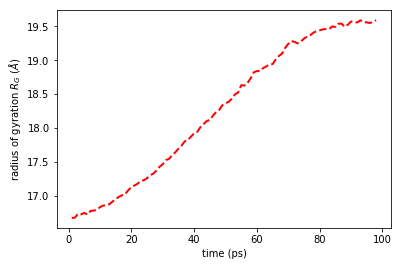

In [48]:
# quick plot
import matplotlib.pyplot as plt
ax = plt.subplot(111)
ax.plot(Rgyr[:,0], Rgyr[:,1], 'r--', lw=2, label=r"$R_G$")
ax.set_xlabel("time (ps)")
ax.set_ylabel(r"radius of gyration $R_G$ ($\AA$)")
ax.figure.savefig("Rgyr.pdf")
plt.draw()

The graph of $R_{G}(t)$ increases over time, indicating an opening up of the AdK enzyme.

#### Exercise 4

1. Take the functions to calculate $\theta_\text{NMP}$ and $\theta_\text{LID}$ and calculate the time series $\theta_\text{NMP}(t)$ and $\theta_\text{LID}(t)$. Plot them together in one plot.
2. Plot $\theta_\text{NMP}(t)$ against $\theta_\text{LID}(t)$. What does the plot show? Why could such a plot be useful?

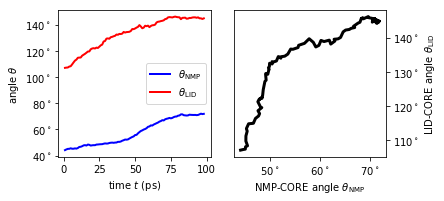

In [49]:
import numpy as np
from numpy.linalg import norm

def theta_NMP(u):
    """Calculate the NMP-CORE angle for E. coli AdK in degrees"""
    C = u.select_atoms("resid 115:125 and (backbone or name CB)").center_of_geometry()
    B = u.select_atoms("resid 90:100 and (backbone or name CB)").center_of_geometry()
    A = u.select_atoms("resid 35:55 and (backbone or name CB)").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

def theta_LID(u):
    """Calculate the LID-CORE angle for E. coli AdK in degrees"""
    C = u.select_atoms("resid 179:185 and (backbone or name CB)").center_of_geometry()
    B = u.select_atoms("resid 115:125 and (backbone or name CB)").center_of_geometry()
    A = u.select_atoms("resid 125:153 and (backbone or name CB)").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

if __name__ == "__main__":
    import MDAnalysis
    from MDAnalysis.tests.datafiles import PSF, DCD
    import matplotlib
    import matplotlib.pyplot as plt

    u = MDAnalysis.Universe(PSF, DCD)
    data = np.array([(u.trajectory.time, theta_NMP(u), theta_LID(u)) for ts in u.trajectory])
    time, NMP, LID = data.T


    # plotting
    degreeFormatter = matplotlib.ticker.FormatStrFormatter(r"%g$^\circ$")
    fig = plt.figure(figsize=(6,3))

    ax1 = fig.add_subplot(121)
    ax1.plot(time, NMP, 'b-', lw=2, label=r"$\theta_{\mathrm{NMP}}$")
    ax1.plot(time, LID, 'r-', lw=2, label=r"$\theta_{\mathrm{LID}}$")
    ax1.set_xlabel(r"time $t$ (ps)")
    ax1.set_ylabel(r"angle $\theta$")
    ax1.yaxis.set_major_formatter(degreeFormatter)
    ax1.legend(loc="best")

    ax2 = fig.add_subplot(122)
    ax2.plot(NMP, LID, 'k-', lw=3)
    ax2.set_xlabel(r"NMP-CORE angle $\theta_{\mathrm{NMP}}$")
    ax2.set_ylabel(r"LID-CORE angle $\theta_{\mathrm{LID}}$")
    ax2.xaxis.set_major_formatter(degreeFormatter)
    ax2.yaxis.set_major_formatter(degreeFormatter)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

    fig.subplots_adjust(left=0.12, right=0.88, bottom=0.2, wspace=0.15)

    for ext in ('svg', 'pdf', 'png'):
        fig.savefig("NMP_LID_angle_projection.{0}".format(ext))


Note that one would normally write the code more efficiently and generate the atom groups once and then pass them to a simple function to calculate the angle

In [50]:
def theta(A, B, C):
    """Calculate the angle between BA and BC for AtomGroups A, B, C"""
    B_center = B.centroid()
    BA = A.centroid() - B_center
    BC = C.centroid() - B_center
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

### Bells and whistles

#### Quick data aquisition

Especially useful for interactive analysis in ipython –pylab using list comprehensions (implicit for loops):

```python
protein = u.select_atoms("protein")
data = np.array([(u.trajectory.time, protein.radius_of_gyration()) for ts in u.trajectory])
time, RG = data.T
plot(time, RG)
```

#### More on the trajectory iterator

One can directly jump to a frame by using “indexing syntax”:

In [51]:
u.trajectory[50]

< Timestep 50 with unit cell dimensions [ 0.  0.  0. 90. 90. 90.] >

In [52]:
ts.frame

0

You can also slice trajectories, e.g. if you want to start at the 10th frame and go to 10th before the end, and only use every 5th frame:

In [53]:
for ts in u.trajectory[9:-10:5]:
    print(ts.frame)

9
14
19
24
29
34
39
44
49
54
59
64
69
74
79
84


**Note**:  Trajectory indexing and slicing uses 0-based indices (as in standard Python) and MDAnalysis also numbers frames starting with 0. Thus the "tenth frame" in a trjectory has `ts.frame == 9`.

## Writing Coordinates

MDAnalysis also supports writing of data in a range of file formats (see the [Table of Supported Coordinate Formats](https://pythonhosted.org/MDAnalysis/documentation_pages/coordinates/init.html#id1) for details). MDAnalysis supports both single frame writers (such as a simple PDB or GRO file) and trajectory writers (e.g. XTC, DCD, but also multi-frame PDB files).

### Single frames

The most straightforward way to write to a file that can only hold a single frame is to use the write() method of any AtomGroup as already also shown under Processing AtomGroups. For instance, to only write out the protein without solvent to a file in GRO format:

In [54]:
from MDAnalysis.tests.datafiles import PDB
uPDB = MDAnalysis.Universe(PDB)
protein = uPDB.select_atoms("protein")
protein.write("protein.gro")

MDAnalysis uses the file suffix to determine the output file format (unless the format keyword is specified) and will raise an exception if it is not suitable for single frame writing.

In [55]:
del uPDB  # clean up this example
os.unlink("protein.gro")

### Trajectories

The typical use pattern is to

1. Get a trajectory writer with `MDAnalysis.Writer()` (which is the same as `MDAnalysis.coordinates.core.writer()`), typically specifying in advance how many atoms a frame will contain.
2. Use the `write()` method to write a new time step to the trajectory.
3. Close the trajectory with `close()` (although it is recommended to simply use the writer with the `with` statement and have the context manager close the file automatically).

#### Example: Protein-only trajectory

In practice, the second step is typically repeated in a loop as in the example below:

In [56]:
import MDAnalysis
from MDAnalysis.tests.datafiles import PDB, XTC

uXTC = MDAnalysis.Universe(PDB, XTC)
protein = uXTC.select_atoms("protein")
with MDAnalysis.Writer("protein.xtc", protein.n_atoms) as W:
    for ts in u.trajectory:
        W.write(protein)

/apps/share64/debian7/anaconda/anaconda2-5.1/lib/python2.7/site-packages/MDAnalysis/coordinates/XDR.py:212: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/apps/share64/debian7/anaconda/anaconda2-5.1/lib/python2.7/site-packages/MDAnalysisTests/data/.adk_oplsaa.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


The loop steps through the input trajectory frame by frame. The coordinates of the selection (the AtomGroup protein) change accordingly and are then written as a new frame into the output trajectory.

The output trajectory only contains the coordinates of the protein. For this trajectory to be useful, a protein-only topology file also has to be stored, as in the example under Single frames.

In [57]:
del uXTC  # clean up this example
os.unlink("protein.xtc")

#### Example: Saving dynamic per-atom properties in B-factor

It is often very useful to project per-atom properties on the structure. A common approach is to save scalar values in the B-factor field of a PDB file and then color atoms by B-factor (also known as temperature factor or just “beta”).

The following example computes the shift of each atom in AdK relative to a reference structure (line 23). We take as reference the closed conformation (after a structural superposition on the CORE domain with alignto()). The shifts are written into the B-factor with the set_bfactor() method of AtomGroup. Each frame is written out as part of a multi-frame PDB file:

In [58]:
# project a dynamic property on the structure using the B-factor field

import numpy as np
import MDAnalysis
import MDAnalysis.analysis.align
from MDAnalysis.core.topologyattrs import Bfactors

from MDAnalysis.tests.datafiles import PSF, DCD


u = MDAnalysis.Universe(PSF, DCD)
u.add_TopologyAttr(Bfactors(np.zeros(len(u.atoms))))
ref = MDAnalysis.Universe(PSF, DCD)  # copy of u

CORE_selection = "resid 1:29 or resid 60:121 or resid 160:214"
pdbtrj = "adk_distance_bfac.pdb"

with MDAnalysis.Writer(pdbtrj, multiframe=True, n_atoms=u.atoms.n_atoms) as PDB:
    # reference coordinates: set to first frame
    ref.trajectory[0]
    # iterate through our trajectory
    for ts in u.trajectory:
        # superimpose on the reference CORE (at t=0)
        rmsd = MDAnalysis.analysis.align.alignto(u.atoms, ref.atoms, select=CORE_selection)
        distances = np.sqrt(np.sum((u.atoms.positions - ref.atoms.positions)**2, axis=1))
        # project displacement on structure via bfactor field
        u.atoms.bfactors = distances
        PDB.write(u.atoms)
        print("Frame {0}: CORE RMSD before/after superposition: {1[0]:.1f} / {1[1]:.1f} A. "
              "min-max displacement: {2:.1f}...{3:.1f} A".format(ts.frame, rmsd, distances.min(), distances.max()))

print("Wrote PDB trajectory {0} with distances in bfactor field".format(pdbtrj))

Frame 0: CORE RMSD before/after superposition: 0.0 / 0.0 A. min-max displacement: 0.0...0.0 A
Frame 1: CORE RMSD before/after superposition: 0.7 / 0.7 A. min-max displacement: 0.0...3.5 A
Frame 2: CORE RMSD before/after superposition: 0.8 / 0.8 A. min-max displacement: 0.0...3.6 A
Frame 3: CORE RMSD before/after superposition: 1.0 / 1.0 A. min-max displacement: 0.0...4.2 A
Frame 4: CORE RMSD before/after superposition: 1.1 / 1.0 A. min-max displacement: 0.0...4.7 A
Frame 5: CORE RMSD before/after superposition: 1.1 / 1.1 A. min-max displacement: 0.0...6.3 A
Frame 6: CORE RMSD before/after superposition: 1.2 / 1.1 A. min-max displacement: 0.1...6.4 A
Frame 7: CORE RMSD before/after superposition: 1.3 / 1.2 A. min-max displacement: 0.1...7.2 A
Frame 8: CORE RMSD before/after superposition: 1.3 / 1.2 A. min-max displacement: 0.1...7.3 A
Frame 9: CORE RMSD before/after superposition: 1.4 / 1.3 A. min-max displacement: 0.0...6.6 A
Frame 10: CORE RMSD before/after superposition: 1.5 / 1.3 A.

Frame 86: CORE RMSD before/after superposition: 3.7 / 2.4 A. min-max displacement: 0.0...23.7 A
Frame 87: CORE RMSD before/after superposition: 3.8 / 2.4 A. min-max displacement: 0.2...24.0 A
Frame 88: CORE RMSD before/after superposition: 3.8 / 2.4 A. min-max displacement: 0.1...24.2 A
Frame 89: CORE RMSD before/after superposition: 3.8 / 2.4 A. min-max displacement: 0.1...23.8 A
Frame 90: CORE RMSD before/after superposition: 3.8 / 2.5 A. min-max displacement: 0.1...24.2 A
Frame 91: CORE RMSD before/after superposition: 3.8 / 2.4 A. min-max displacement: 0.1...24.2 A
Frame 92: CORE RMSD before/after superposition: 3.8 / 2.4 A. min-max displacement: 0.1...24.0 A
Frame 93: CORE RMSD before/after superposition: 3.8 / 2.4 A. min-max displacement: 0.1...24.1 A
Frame 94: CORE RMSD before/after superposition: 3.8 / 2.4 A. min-max displacement: 0.1...24.2 A
Frame 95: CORE RMSD before/after superposition: 3.8 / 2.4 A. min-max displacement: 0.1...24.2 A
Frame 96: CORE RMSD before/after superpo

## Using the MDAnalysis.analysis Modules

MDAnalysis comes with a number of existing analysis code in the `MDAnalysis.analysis` module and example scripts (see also the Examples on the MDAnalysis wiki).

### RMSD

As an example we will use the MDAnalysis.analysis.rms.rmsd() function from the MDAnalysis.analysis.rms module. It computes the coordinate root mean square distance between two sets of coordinates. For example for the AdK trajectory the backbone RMSD between first and last frame is

In [59]:
import MDAnalysis.analysis.rms
u = MDAnalysis.Universe(PSF, DCD)
bb = u.select_atoms('backbone')
A = bb.positions  # coordinates of first frame
u.trajectory[-1]      # forward to last frame
B = bb.positions  # coordinates of last frame
MDAnalysis.analysis.rms.rmsd(A,B)

6.852774844656239

### Superposition of structure

In order to superimpose two structures in a way that minimizes the RMSD we have functions in the MDAnalysis.analysis.align module.

The example uses files provided as part of the MDAnalysis test suite (in the variables PSF, DCD, and PDB_small). For all further examples execute first

In [60]:
import MDAnalysis
from MDAnalysis.analysis import align, rms
from MDAnalysis.tests.datafiles import PSF, DCD, PDB_small

In the simplest case, we can simply calculate the C-alpha RMSD between two structures, using rmsd():

In [61]:
ref = MDAnalysis.Universe(PDB_small)
mobile = MDAnalysis.Universe(PSF,DCD)
rms.rmsd(mobile.atoms.CA.positions, ref.atoms.CA.positions)

/apps/share64/debian7/anaconda/anaconda2-5.1/lib/python2.7/site-packages/MDAnalysis/core/topologyattrs.py:507: DeprecationWarning: Instant selector AtomGroup['<name>'] or AtomGroup.<name> is deprecated and will be removed in 1.0. Use AtomGroup.select_atoms('name <name>') instead.
  DeprecationWarning)


28.20178579474479

Note that in this example translations have not been removed. In order to look at the pure rotation one needs to superimpose the centres of mass (or geometry) first:

In [62]:
ref0 =  ref.atoms.CA.positions - ref.atoms.CA.center_of_mass()
mobile0 =  mobile.atoms.CA.positions - mobile.atoms.CA.center_of_mass()
rms.rmsd(mobile0, ref0)

21.892591663632704

The rotation matrix that superimposes mobile on ref while minimizing the CA-RMSD is obtained with the rotation_matrix() function

In [63]:
R, rmsd = align.rotation_matrix(mobile0, ref0)
print rmsd

6.80939658647


In [64]:
print R

[[ 0.14514539 -0.27259113  0.95111876]
 [ 0.88652593  0.46267112 -0.00268642]
 [-0.43932289  0.84358136  0.30881368]]


Putting all this together one can superimpose all of mobile onto ref:

In [65]:
mobile.atoms.translate(-mobile.atoms.CA.center_of_mass())
mobile.atoms.rotate(R)
mobile.atoms.translate(ref.atoms.CA.center_of_mass())
mobile.atoms.write("mobile_on_ref.pdb")

#### Exercise 5

Use the above in order to investigate how rigid the CORE, NMP, and LID domains are during the transition: Compute time series of the CA RMSD of each domain relative to its own starting structure, when superimposed on the starting structure.

The code contains a function superpose() and rmsd(). The latter is marginally faster because we only need the calculated RMSD and not the full rotation matrix. (We are calling the lower-level function MDAnalysis.core.qcprot.CalcRMSDRotationalMatrix() directly, which has somewhat non-intuitive calling conventions). superpose() also does the superposition of the mobile group to the references (but alignto() is actually a more flexible tool for doing this). Otherwise it is mostly book-keeping, which is solved by organizing everything in dictionaries with keys “CORE”, “NMP”, “LID”.

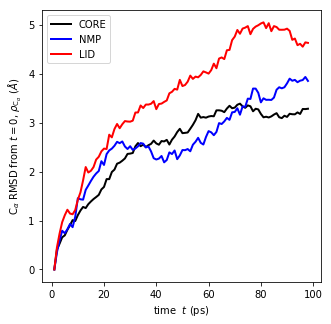

In [66]:
import numpy as np
from MDAnalysis.analysis.align import rotation_matrix
from MDAnalysis.lib.qcprot import CalcRMSDRotationalMatrix

def superpose(mobile, xref0, xref_com=None):
    """Superpose the AtomGroup *mobile* onto the coordinates *xref0* centered at the orgin.

    The original center of mass of the reference group *xref_com* must
    be supplied or the superposition is done at the origin of the
    coordinate system.
    """
    # 995 us
    xref_com = xref_com if xref_com is not None else np.array([0., 0., 0.])
    xmobile0 = mobile.positions - mobile.center_of_mass()
    R, rmsd = rotation_matrix(xmobile0, xref0)
    mobile.rotate(R)
    mobile.translate(xref_com)
    return rmsd

def rmsd(mobile, xref0):
    """Calculate optimal RMSD for AtomGroup *mobile* onto the coordinates *xref0* centered at the orgin.

    The coordinates are not changed. No mass weighting.
    """
    # 738 us
    xmobile0 = mobile.positions - mobile.center_of_mass()
    return CalcRMSDRotationalMatrix(xref0.T.astype(np.float64), xmobile0.T.astype(np.float64), mobile.n_atoms, None, None)


if __name__ == "__main__":
    import MDAnalysis
    import matplotlib
    import matplotlib.pyplot as plt

    # load AdK DIMS trajectory
    from MDAnalysis.tests.datafiles import PSF, DCD
    u = MDAnalysis.Universe(PSF, DCD)

    # one AtomGroup per domain
    domains = {
        'CORE': u.select_atoms("(resid 1:29 or resid 60:121 or resid 160:214) and name CA"),
        'LID': u.select_atoms("resid 122-159 and name CA"),
        'NMP': u.select_atoms("resid 30-59 and name CA"),
        }
    colors = {'CORE': 'black', 'NMP': 'blue', 'LID': 'red'}

    u.trajectory[0]   # rewind trajectory
    xref0 = dict((name, g.positions - g.center_of_mass()) for name,g in domains.iteritems())

    nframes = len(u.trajectory)
    results = dict((name, np.zeros((nframes, 2), dtype=np.float64)) for name in domains)

    for iframe,ts in enumerate(u.trajectory):
        for name, g in domains.iteritems():
            results[name][iframe, :] = u.trajectory.time, rmsd(g, xref0[name])


    # plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    for name in "CORE", "NMP", "LID":
        data = results[name]
        ax.plot(data[:,0], data[:,1], linestyle="-", color=colors[name], lw=2, label=name)
    ax.legend(loc="best")
    ax.set_xlabel(r"time  $t$ (ps)")
    ax.set_ylabel(r"C$_\alpha$ RMSD from $t=0$, $\rho_{\mathrm{C}_\alpha}$ ($\AA$)")

    for ext in ('svg', 'pdf', 'png'):
        fig.savefig("AdK_domain_rigidity.{0}".format(ext))